In [1]:
import numpy
print(numpy.__version__)
import networkx
print(networkx.__version__)

from nilmtk.api import API
import warnings

warnings.filterwarnings("ignore")
from nilmtk.disaggregate import DM_SDA, GaterSGN, SGN, DM_GATE2
import nilmtk.utils as utils

1.24.3
2.8.4


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
# import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

# from src import *

USE_GPU = True
device = torch.device("cuda:0" if USE_GPU and torch.cuda.is_available() else "cpu")
print(torch.__version__, device)

2.0.1 cuda:0


SGN
Started training for  SGN
Joint training for  SGN
............... Loading Data for training ...................
Loading data for  redd  dataset
Loading building ...  3
Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')     {'fill_method': None, 'how': 'mean'}
Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     {'fill_method': None, 'how': 'mean'}

Done loading data all meters for this chunk.
{'fill_method': None, 'how': 'mean'}
Dropping missing values
Train Jointly
Loading transfer data for  redd  dataset
Loading building ...  3
Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')     {'fill_method': None, 'how': 'mean'}
Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     {'fill_method': None, 'how': 'mean'}

Done loading data all meters for this chunk.
{'fill_method': None, 'how': 'mean'}
Dropping missing values
Transfer Jointly
...............SGN partial_fit running...............


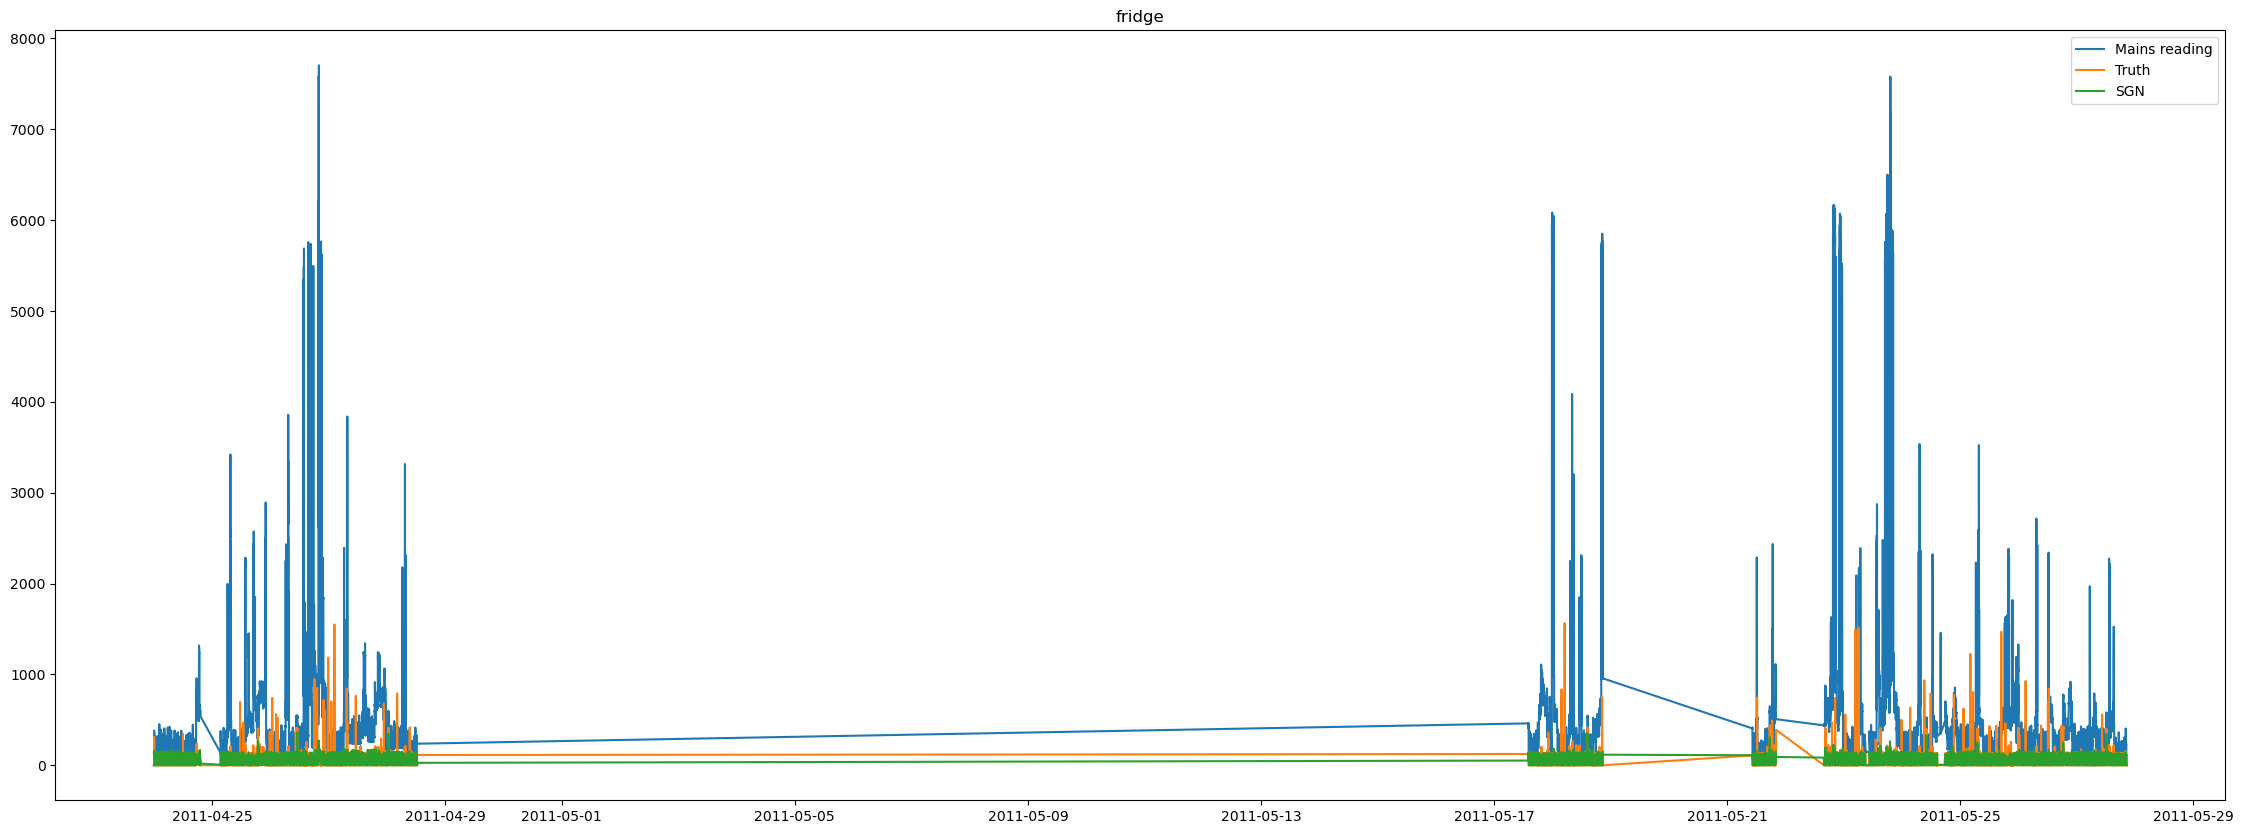

............  accuracy  ..............
             SGN
fridge  0.923209
............  f1score  ..............
             SGN
fridge  0.904681
............  mae  ..............
              SGN
fridge  16.057337
............  sae  ..............
             SGN
fridge  7.705301
............  precision  ..............
             SGN
fridge  0.890777
............  recall  ..............
             SGN
fridge  0.919027
............  nep  ..............
             SGN
fridge  0.319058
............  MCC  ..............
             SGN
fridge  0.840701


In [3]:
DATASET_NAME = 'redd'
HOUSE = 3
TUNE = True
MODEL_NOTE = f"ft_{HOUSE}"

if HOUSE == 1:
    TRAIN = {
        1: {
            'start_time': '2011-04-19',
            'end_time': '2011-04-26'
        },
    }
    TEST = {
        1: {
            'start_time': '2011-04-26',
            'end_time': '2011-05-24'
        },
    }
elif HOUSE == 2:
    TRAIN = {
        2: {
            'start_time': '2011-04-18',
            'end_time': '2011-04-25'
        },
    }
    TEST = {
        2: {
            'start_time': '2011-04-25',
            'end_time': '2011-05-22'
        },
    }
elif HOUSE == 3:
    TRAIN = {
        3: {
            'start_time': '2011-04-17',
            'end_time': '2011-04-24'
        },
    }
    TEST = {
        3: {
            'start_time': '2011-04-24',
            'end_time': '2011-05-30'
        },
    }
else:
    raise NameError

e = {
    # Specify power type, sample rate and disaggregated appliance
    'power': {
        'mains_train': ['apparent'],
        'mains_transfer': ['apparent'],
        'mains_test': ['apparent'],
                
        # 'appliance': ['active']
        # 'mains': ['apparent'],  # problem: ukdale active, redd apparent
        'appliance': ['active'],
    },
    'sample_rate': 6,
    # 'appliances': ['washing machine'],
    'appliances': ['fridge'],
    # Universally no pre-training
    'pre_trained': False,
    "app_meta": utils.GENERAL_APP_META,
    # Specify algorithm hyper-parameters
    # 'gater': 
    #     # "GaterSGN": GaterSGN(
    #     # {'n_epochs': 10, 'batch_size': 256, 'test_only': False}),
    #     SGN({'n_epochs': 5, 'batch_size': 256, 'test_only': True, 'gate_only': True, 'note': 'ukdale'})
    #     ,
    'save_note': f'ft-{HOUSE}' if TUNE else f'ft-{HOUSE}-no',
    'methods': {
        # "DM_GATE2": DM_GATE2(
        #     {'n_epochs': 5, 'batch_size': 64, 'sequence_length': 720, 'overlapping_step': 10,
        #     'test_only': True, 'fine_tune': TUNE, 'src_rate': 0.0, 'lr': 5e-6, "sampler": "ddim", "patience": 3,
        #     'freeze': True,
        #     "app_meta": utils.APP_META[DATASET_NAME], 'filter_train': False, 'note': DATASET_NAME, 'load_from': 'ukdale'})
        
        "SGN": SGN(
            {'n_epochs': 20, 'batch_size': 256,
             'sequence_length': 200, 'appliance_length': 32,
             'test_only': True, 'gate_only': False, 'fine_tune': TUNE,
             'note': MODEL_NOTE, 'load_from': 'ukdale',
             'patience': 3}
        )
    },
    # Specify train and test data
    'train': {
        'datasets': {
            # 'ukdale': {
            #     'path': 'mnt/ukdale.h5',
            #     'buildings': {
            #         1: {
            #             'start_time': '2013-05-31',
            #             'end_time': '2013-08-31'
            #         },
            #         5: {
            #             'start_time': '2014-07-01',
            #             'end_time': '2014-09-05'
            #         },
            #     }
            # },
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': TRAIN
            },
        }
    },
    'transfer': {
        'datasets': {
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': TRAIN
            },
        },
    },
    'test': {
        'datasets': {
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': TEST
            },
        },
        # Specify evaluation metrics
        'metrics': ['accuracy', 'f1score', 'mae', 'sae', 'precision', 'recall', 'nep', 'MCC']
    }
}

API(e)